In [60]:
import datasets
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet, words
from nltk.stem import WordNetLemmatizer
import nltk

lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('wordnet')
en_stopwords = set(stopwords.words('english'))

data = datasets.load_dataset("wikipedia", "20220301.en", streaming=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Yourui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Yourui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
next(iter(data['train']))['text']

'Anarchism is a political philosophy and movement that is sceptical of authority and rejects all involuntary, coercive forms of hierarchy. Anarchism calls for the abolition of the state, which it holds to be unnecessary, undesirable, and harmful. As a historically left-wing movement, placed on the farthest left of the political spectrum, it is usually described alongside communalism and libertarian Marxism as the libertarian wing (libertarian socialism) of the socialist movement, and has a strong historical association with anti-capitalism and socialism.\n\nHumans lived in societies without formal hierarchies long before the establishment of formal states, realms, or empires. With the rise of organised hierarchical bodies, scepticism toward authority also rose. Although traces of anarchist thought are found throughout history, modern anarchism emerged from the Enlightenment. During the latter half of the 19th and the first decades of the 20th century, the anarchist movement flourished 

In [3]:
data['train']

IterableDataset({
    features: ['id', 'url', 'title', 'text'],
    n_shards: 41
})

In [4]:
import string

def tokenize(sentence):
    tokenized = word_tokenize(sentence.translate(str.maketrans('', '', string.punctuation)))
    return [lemmatizer.lemmatize(token) for token in tokenized if token not in en_stopwords and wordnet.synsets(token)]

In [5]:
tokenize(sent_tokenize(next(iter(data['train']))['text'].lower())[0])

['anarchism',
 'political',
 'philosophy',
 'movement',
 'sceptical',
 'authority',
 'reject',
 'involuntary',
 'coercive',
 'form',
 'hierarchy']

In [6]:
import contextlib
import numpy as np

def generate_frequencies(word, n_occurrences=10000, deltas=None):
    if deltas is None:
        deltas = [-4, -3, -2, -1, 1, 2, 3, 4]
    word = lemmatizer.lemmatize(word)

    frequencies = {}
    occurrences = 0

    for i, row in enumerate(data['train']):
        sentences = sent_tokenize(row['text'].lower())

        for sentence in sentences:
            tokenized = tokenize(sentence)
            indices = [i for i, x in enumerate(tokenized) if x == word]

            if indices:
                for index in indices:
                    for delta in deltas:
                        with contextlib.suppress(IndexError):
                            try:
                                frequencies[tokenized[index + delta]] += 1
                            except KeyError:
                                frequencies[tokenized[index + delta]] = 1

                occurrences += 1
                if occurrences >= n_occurrences:
                    return frequencies

        if i % 1000 == 0:
            print(f'"{word}", {i}th row processed, {occurrences}/{n_occurrences} occurrences')

In [7]:
# keep only the most frequently occurring words next to the target word (ex: 1000+ occurrences) + aggregate those words + collect data
    # Table 1: Most frequent words
    # Table 2: Most frequent words with count vectors
# test discarding bits with high variance values

In [8]:
import json

def store_encoding(word, fname, args):
    frequencies = generate_frequencies(word, **args)
    
    with open(fname, 'r') as f:
        encodings = json.load(f)
    encodings[word] = frequencies
    with open(fname, 'w') as f:
        json.dump(encodings, f, indent=4)

In [9]:
l = ["man","woman","king","queen"]

for value in l:
    store_encoding(value, 'frequencies.json', {'n_occurrences':20000, 'deltas': [-2, -1, 1, 2]})

"man", 0th row processed, 0/20000 occurrences
"man", 1000th row processed, 795/20000 occurrences
"man", 2000th row processed, 1411/20000 occurrences
"man", 3000th row processed, 2105/20000 occurrences
"man", 4000th row processed, 2836/20000 occurrences
"man", 5000th row processed, 3643/20000 occurrences
"man", 6000th row processed, 4488/20000 occurrences
"man", 7000th row processed, 5323/20000 occurrences
"man", 8000th row processed, 6639/20000 occurrences
"man", 9000th row processed, 7343/20000 occurrences
"man", 10000th row processed, 8143/20000 occurrences
"man", 11000th row processed, 8753/20000 occurrences
"man", 12000th row processed, 9487/20000 occurrences
"man", 13000th row processed, 10225/20000 occurrences
"man", 14000th row processed, 10839/20000 occurrences
"man", 15000th row processed, 11640/20000 occurrences
"man", 16000th row processed, 12643/20000 occurrences
"man", 17000th row processed, 13550/20000 occurrences
"man", 18000th row processed, 13693/20000 occurrences
"man

In [86]:
with open('frequencies.json', 'r') as f:
    frequencies = json.load(f)

In [87]:
top_100_freq = {
    key: dict(
        sorted(
            frequencies[key].items(), key=lambda item: item[1], reverse=True
        )[:100]
    )
    for key in frequencies.keys()
}
with open('top_frequencies.json', 'w') as f:
    json.dump(top_100_freq, f, indent=4)

In [73]:
import mmh3
from bitarray import bitarray

def hash_token(token, bits):
    bit_array = bitarray(bits)
    bit_array.setall(0)
    
    for i in range(3):
        digest = mmh3.hash(token, i) % bits
        bit_array[digest] = True
    return bit_array

In [80]:
representations = {}
for key in top_100_freq.keys():
    w_representation = np.zeros(32, dtype=int)
    representations[key] = {'indv':{}, 'total':None}
    for word in top_100_freq[key].keys():
        representations[key]['indv'][word] = list(hash_token(word, 32))
        w_representation += np.array(list(hash_token(word, 32))) * top_100_freq[key][word]
    representations[key]['total'] = w_representation.tolist()

In [81]:
with open('representations.json', 'w') as f:
    json.dump(representations, f, indent=4)

In [82]:
arr = []
for representation in representations.values():
    arr += representation['total']
representation_16_array = np.array(arr).reshape((4,-1))

([<matplotlib.axis.YTick at 0x324ffe000>,
 [Text(0, 0, 'man'),
  Text(0, 1, 'woman'),
  Text(0, 2, 'king'),
  Text(0, 3, 'queen')])

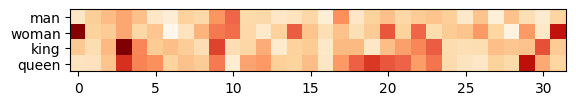

In [83]:
import matplotlib.pyplot as plt
plt.imshow(representation_16_array, cmap='OrRd')
plt.yticks(ticks=np.arange(4), labels=representations.keys())